# Добыча золота

**Исходные данные:** 
данные с параметрами добычи и очистки


**Цель:**
подготовить прототип модели для предсказания коэффициента восстановления золота из руды, для оптимизации производства и снижения убытков на этапе подготовки к запуску процессов



**Этапы исследования:**

1.   Загрузка исходных данных и их общая оценка
    * проверка расчета эффективность обогащения(найти MAE между расчетным значением и значением признака)
    * проанализировать признаки, недоступные в тестовой выборке
2. Предобработка данных
3. Анализ данных:
    * оценка изменения концентрация металлов (Au, Ag, Pb) на различных этапах очистки
    * сравнение распределения размеров гранул сырья на обучающей и тестовой выборках
    * исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах 
4. Обучение и тестирование модели

5. Заключение


## 1 Загрузка исходных данных

In [1]:
!pip install --upgrade matplotlib --quiet install
!pip install shap --quiet install
!pip install xgboost --quiet install
!pip install optuna --quiet install
!pip install schemdraw --quiet install
!pip install seaborn --upgrade --quiet install

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

import re
import schemdraw
import shap
import optuna
import xgboost as xgb

from schemdraw.flow import *

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import RobustScaler


RANDOM_STATE = 42

In [3]:
class ShowData:    
    def download_data(self, path):
        if "MyDrive/Yandex" in path:
            from google.colab import drive
            drive.mount('/content/drive')
            df = pd.read_csv(path)
        else:
            df = pd.read_csv(path)
        return df

    def change_data(self, df):
        df.columns = (df.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.lower())
        try:
            for name in df.select_dtypes("number").columns:
                df[name] = pd.to_numeric(df[name], downcast="integer" 
                                        if df[name].dtype == "int" 
                                        else "float")
        except:
            pass    
        return df
    
    def general_info(self, df):
        info_0 = pd.DataFrame(df.dtypes.value_counts(), columns=[""])
        info_0.loc["columns", ""] = len(df.columns)
        info_0.loc["row", ""] = len(df)
        info_0.loc["memory_usage, MB", ""] = df.memory_usage()\
        .sum() / (1024 ** 2)
    
        return info_0

    def deep_info(self, df):
        info_1 = pd.DataFrame(index=df.columns, columns=['rows'], data=len(df))
        info_1["null_row"] = df.apply(lambda x: x == 0, axis=1).sum()
        info_1["uniq"] = df.nunique()
        info_1["dup_val"] = [df[i].duplicated().sum() for i in df]
        info_1["dup_row"] = df.duplicated().sum()
        info_1["NaN"] = df.isna().sum()
        info_1["NaN,%"] = df.isna().mean()
        info_1["type"] = df.dtypes
        info_1 = info_1.join(df.describe(include="number")["mean":].transpose())
        info_1.fillna("", inplace=True)
        for col in info_1.loc[:, "mean":]:
            info_1[col] = pd.to_numeric(info_1[col], downcast="float")
        info_1["null_row"] = pd.to_numeric(info_1["null_row"], downcast="integer")
        info_1["outliers"] = info_1["max"] > info_1["75%"] \
                             + 1.5 * (info_1["75%"] - info_1["25%"])

        prop = {
            "border": "0.5px solid black", 
            "width": "85px", 
            "text-align": "center"   
        }
        percent = {
            "NaN,%":"{:.3%}",
            "mean":"{:.3}",
            "std":"{:.3}",	
            "min":"{:.3}",	
            "25%":"{:.3}",	
            "50%":"{:.3}",	
            "75%":"{:.3}",	
            "max":"{:.3}",
        } 
        return info_1, info_1.style.format(percent).set_properties(**prop)
    
    def histbox(self, df):
        length = len(df.columns)
        df_num = df.select_dtypes("number")
        fig = plt.figure(figsize=(length*3,length))
        sfigs = fig.subfigures(round(length/4), 4)
        for i, axes in enumerate(sfigs.flat):
            try:
                axes.suptitle(df_num.columns[i])
                if len(df.iloc[:,i]) > 0:
                    ax_1= axes.subplots(2, 1, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})
                    sns.boxplot(data=df, x=df_num.columns[i], orient="h", 
                                ax=ax_1[0])
                    sns.histplot(data=df, x=df_num.columns[i], kde=True, 
                                 ax=ax_1[1])
                    plt.xlabel("")
                    plt.ylabel("")
            except:
                break
        plt.show()

    def cor_matrix(self, df):
        length = len(df.columns)
        plt.figure(figsize=(length, length))
        sns.heatmap(df.corr(method="pearson"), annot=True, linewidths=0.3,
            cmap="coolwarm", square=True)
        plt.show()



In [4]:
sd = ShowData()

In [5]:
df_full = sd.download_data("gold_recovery_full_new.csv")
X_train = sd.download_data("gold_recovery_train_new.csv")
X_test = sd.download_data("gold_recovery_test_new.csv")

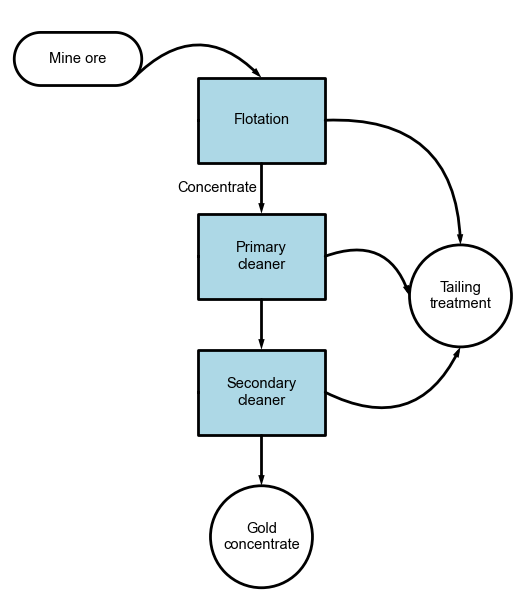

In [6]:
with schemdraw.Drawing() as d:
    # define size of text and length of arrows
    d.config(fontsize=12, unit=1.2)
    # steps and arrows for the steps 
    # crushing and griding raw ore before floating 
    d += (a := Start(r=1.2)).label("Mine ore")
    d += Arc2(arrow='->').at(a.SE)
    # gold minerals are concentrated via gravity concentration and flotation
    d += (a1 := Process()).label("Flotation").fill('lightblue')
    # send a concentrate to leaching process
    d += Arrow().label("Concentrate")
    d += (a3 := Process()).label("Primary\ncleaner").fill('lightblue')
    d += Arrow()
    d += (a4 := Process()).label("Secondary\ncleaner").fill('lightblue')
    d += Arrow()
    d += Connect(r=1.2).label("Gold\nconcentrate")
    # after floations and stays a slag
    d += (b := Connect(r=1.2)).label("Tailing\ntreatment").at((9, -5))
    d += Arc2(arrow='->').at(a1.E).to(b.N)
    d += Arc2(arrow='->').at(a3.E).to(b.W)
    d += Arc2(arrow='<-').at(b.S).to(a4.E)

Диаграмма, представленная выше, обеспечивает общее представление о технологическом процессе и также отражает данные, представленные в наборах данных. Поскольку разделение набора данных на тестовый и обучающий наборы уже было выполнено, необходимо проверить правильность этих данных и использовать их в случае успешных результатов. Полный набор данных будет использоваться для получения целевой функции на этапе окончательной проверки модели.

In [7]:
# show the general information about data
sd.general_info(X_train)

float64              86.000000
object                1.000000
columns              87.000000
row               14149.000000
memory_usage, MB      9.391624

In [8]:
sd.general_info(X_test)

float64             52.000000
object               1.000000
columns             53.000000
row               5290.000000
memory_usage, MB     2.139175

In [9]:
len(X_test) / len(X_train)

0.3738780125803944

Количество столбцов в тестовой выборке не совпадает с количеством столбцов обучающей выборки, что будет рассматриваться ниже. Соотношение данных приблизительно соотносится с классическим 20/80 или 25/75

In [10]:
sd.deep_info(X_train)[1]

In [11]:
sd.deep_info(X_test)[1]

In [12]:
# what the percent of null rows
print(f'Train data null-row {sd.deep_info(X_train)[0]["null_row"].sum() / len(X_train): .2%}')
print(f'Train data NAN-row {sd.deep_info(X_train)[0]["NaN,%"].sum(): .3f}')
print(f'Test data null-row {sd.deep_info(X_test)[0]["null_row"].sum() / len(X_test): .2%}')
print(f'Test data NAN-row {sd.deep_info(X_test)[0]["NaN,%"].sum(): .3f}')

Train data null-row  39.73%
Train data NAN-row  0.290
Test data null-row  0.02%
Test data NAN-row  0.017


Обучающий датасет имеет больше пропусков и нулевых строк, чем тестовый. Возможно именно эти признаки отсутствуют в тестовой выборке. В данных присутствует временной столбец. От времени зависят все процессы протекающие при получении золота из руды, поэтому этот столбец стоит обратить в индексы. Большинство столбцов явно имеют выбросы, предварительно необходимо оценить разброс значений

In [13]:
# let's see on the data columns
X_test["date"].head(3)

0    2016-09-01 00:59:59
1    2016-09-01 01:59:59
2    2016-09-01 02:59:59
Name: date, dtype: object

In [14]:
# change the data types
df_full["date"] = pd.to_datetime(df_full["date"], yearfirst=True)
X_test["date"] = pd.to_datetime(X_test["date"], yearfirst=True)
X_train["date"] = pd.to_datetime(X_train["date"], yearfirst=True)
X_test["date"].head(3)

0   2016-09-01 00:59:59
1   2016-09-01 01:59:59
2   2016-09-01 02:59:59
Name: date, dtype: datetime64[ns]

In [15]:
# show the year-month-day distribution
pd.DatetimeIndex(X_test["date"]).year

Int64Index([2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='date', length=5290)

Разброс значений даты приходится, в том числе, и на годы, так что оставим дату в полном формате

In [16]:
# graphs for columns where the mean is similar
def box_bins(df):
    # call the function what show statistic data
    stats = ShowData().deep_info(df)[0]
    # create the bins for the mean values
    bins = pd.qcut(stats["mean"], 12, precision=2)
    figure, axis = plt.subplots(nrows=12, ncols=1, figsize=(10, 33))
    # show boxplot for each category
    for i, category in enumerate(bins.cat.categories):
        index_labels = bins[bins == category].index
        sns.boxplot(data=df.loc[:, index_labels], orient="h", ax=axis[i])
        axis[i].set_title("Boxplots with median belonging to "+str(category))
        axis[i].set_xlabel("Values")
    plt.tight_layout()

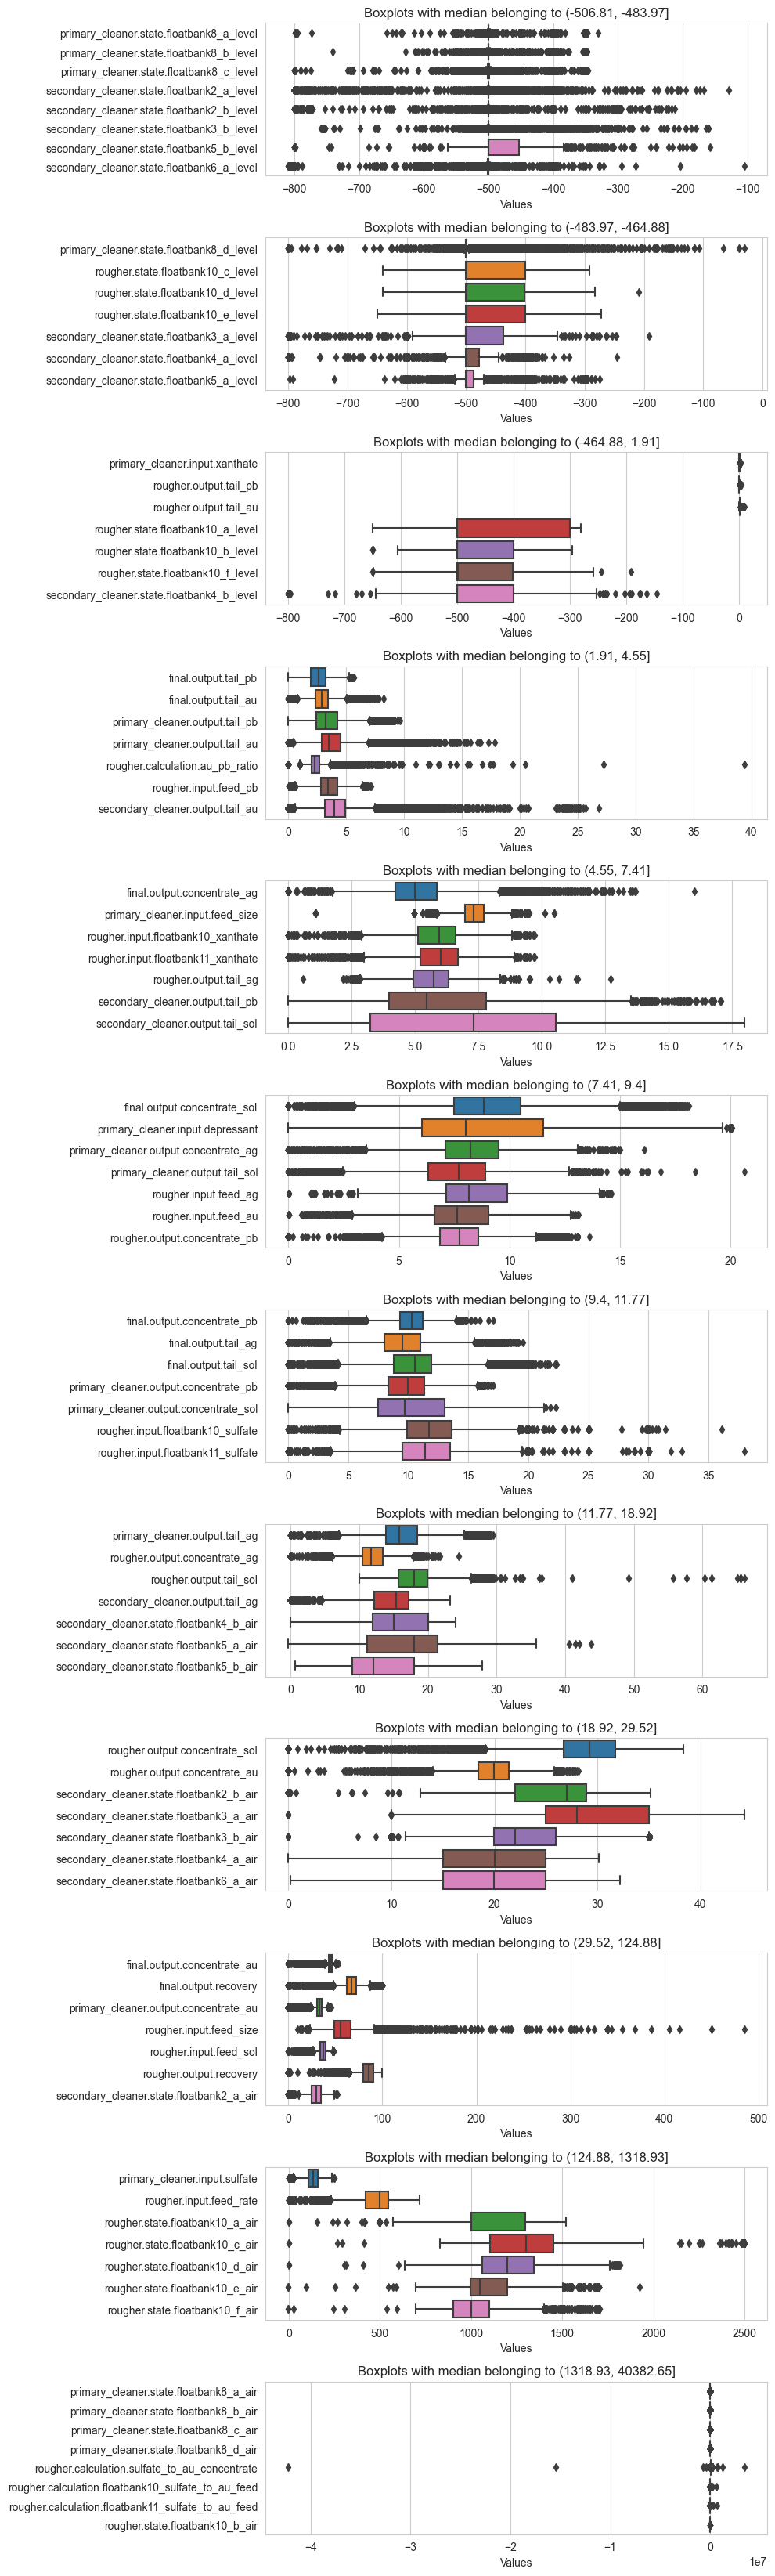

In [17]:
box_bins(X_train)

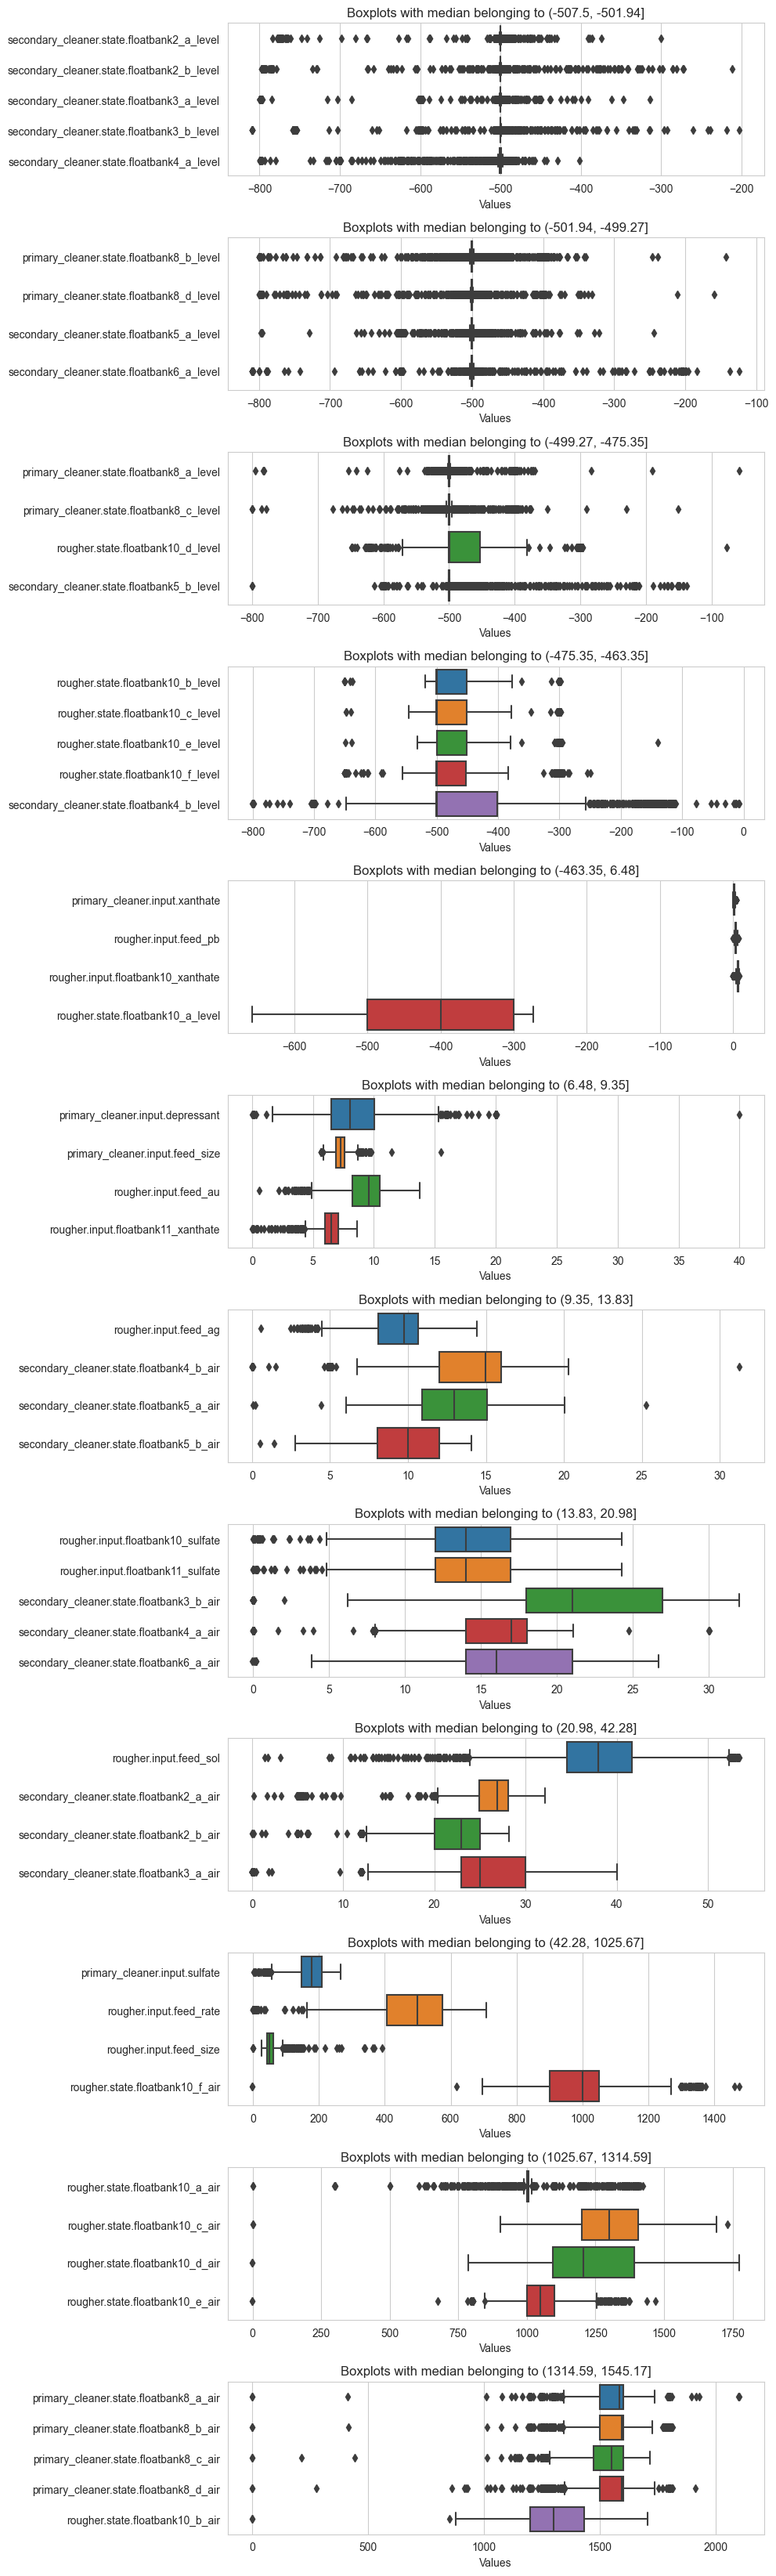

In [18]:
box_bins(X_test)

Довольно много выбросов и это необходимо учесть при выборе масштабирования и модели. Для построения модели необходимо сократить количество выбросов.

### Проверка расчета эффективность обогащения

In [19]:
C = X_train["rougher.output.concentrate_au"]
F = X_train["rougher.input.feed_au"]
T = X_train["rougher.output.tail_au"]
recovery = pd.DataFrame((C * (F - T)) / (F * (C - T)) * 100, columns=["calculate"])
recovery["true_val"] = X_train["rougher.output.recovery"].fillna(0)
enrichment = mean_absolute_error(recovery.iloc[:, 1], recovery.iloc[:, 0])
print(f"With an ideal MAE - 0, the error is {enrichment}")

With an ideal MAE - 0, the error is 9.73512347450521e-15


Рассчитанная характеристика обогащения и признак из обучающей выборки отличаются довольно мало, исходя из значения абсолютной ошибки, которая стремится к нулю. Так как признак является расчетным необходимо оценить корреляцию и отбросить данных признак, чтобы исключить мультиколлинеарность.

### Признаки вне тестовой выборки

In [20]:
difference = pd.DataFrame(index=df_full.columns, columns=["test", "train"])
difference["train"] = True
difference["test"] = [i in X_test.columns for i in difference.index]
difference[difference.test != True]

test  train
final.output.concentrate_ag                         False   True
final.output.concentrate_pb                         False   True
final.output.concentrate_sol                        False   True
final.output.concentrate_au                         False   True
final.output.recovery                               False   True
final.output.tail_ag                                False   True
final.output.tail_pb                                False   True
final.output.tail_sol                               False   True
final.output.tail_au                                False   True
primary_cleaner.output.concentrate_ag               False   True
primary_cleaner.output.concentrate_pb               False   True
primary_cleaner.output.concentrate_sol              False   True
primary_cleaner.output.concentrate_au               False   True
primary_cleaner.output.tail_ag                      False   True
primary_cleaner.output.tail_pb                      False   True
primary_cleaner.output.tail_sol                     False   True
primary_cleaner.output.tail_au                      False   True
rougher.calculation.sulfate_to_au_concentrate       False   True
rougher.calculation.floatbank10_sulfate_to_au_feed  False   True
rougher.calculation.floatbank11_sulfate_to_au_feed  False   True
rougher.calculation.au_pb_ratio                     False   True
rougher.output.concentrate_ag                       False   True
rougher.output.concentrate_pb                       False   True
rougher.output.concentrate_sol                      False   True
rougher.output.concentrate_au                       False   True
rougher.output.recovery                             False   True
rougher.output.tail_ag                              False   True
rougher.output.tail_pb                              False   True
rougher.output.tail_sol                             False   True
rougher.output.tail_au                              False   True
secondary_cleaner.output.tail_ag                    False   True
secondary_cleaner.output.tail_pb                    False   True
secondary_cleaner.output.tail_sol                   False   True
secondary_cleaner.output.tail_au                    False   True

Столбцы обучающего датасета полностью соответствуют столбцам полного датасета, в то время как в тестовом отсутствуют выходыне характеристики всех этапов, такие как содержание металлов в шлаковых хвостах и концентрате, а так же вычисленные значения обогащения, содержания сульфатов в концентрате и т.д. Эти признаки очевидно получены позднее, чем измеряются те, что составляют тестовую выборку

### Вывод

В данных присутствует временной столбец, от которого зависят все процессы при получении золота из руды, поэтому этот столбец стоит обратить в индексы. В таком случае нам удастся заполнить пропуски в данных посредством соседних значений. Найденные нулевые значения придется удалить, потому что нулевые содержания металлов представляют собой нарушение технологического процесса или же нарушение в измерении веществ, что отрицательно скажется на результатах обучения и предсказания модели. Уточнить дополнительные сведения у заказчика так же не представляется возможным. Но в первую очередь стоит обратить внимание на лишние столбцы в обучающей выборке и удалить их, для того чтобы исключить момент переобучения модели или соотнести выборку с тестовой. Отмеченные выбросы необходимо сократить в разумных пределах в рамках обучающей выборки, оставляя большую часть данных для последующей работы.

Подводя итог:

1. Столбцу с датой присвоить соответствующий тип и конвертировать в индексы
2. Удалить столбцы из обучающей выборки, отсутствующие в тестовой
3. Удалить строки с нулевыми значениями
4. Заполнить пропуски соседними значениями
5. Сократить выбросы

## 2 Предобработка данных

In [21]:
# work with date columns
df_full.index = df_full["date"]
df_full.drop("date", axis=1, inplace=True)
X_train.index = X_train["date"]
X_train.drop("date", axis=1, inplace=True)
X_test.index = X_test["date"]
X_test.drop("date", axis=1, inplace=True)

In [22]:
X_train.shape, X_test.shape

((14149, 86), (5290, 52))

In [23]:
# count the NUMBER of null ROWS in test sample
len(X_train[(X_train == 0).any(axis=1)]), len(X_test[(X_test == 0).any(axis=1)])

(1213, 1)

In [24]:
# remove a row with inside and check the size
X_test = X_test[(X_test != 0).all(axis=1)]
X_train = X_train[(X_train != 0).all(axis=1)]
X_test.shape, X_train.shape

((5289, 52), (12936, 86))

In [25]:
len(X_test[(X_test.isna()).any(axis=1)]), len(X_train[(X_train.isna()).any(axis=1)])

(60, 2651)

In [26]:
def miss_val(df, features):

    df_old = df
    df = df.ffill()
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_old, x=features, kde=True, label="before")
    sns.histplot(data=df, x=features, kde=True, label="ffill")
    plt.legend(loc='upper right')
    plt.title("Distribution of data before and after filling NaN values "
              "on the example of one column")
    plt.xlabel("Values")
    plt.show()

    return df

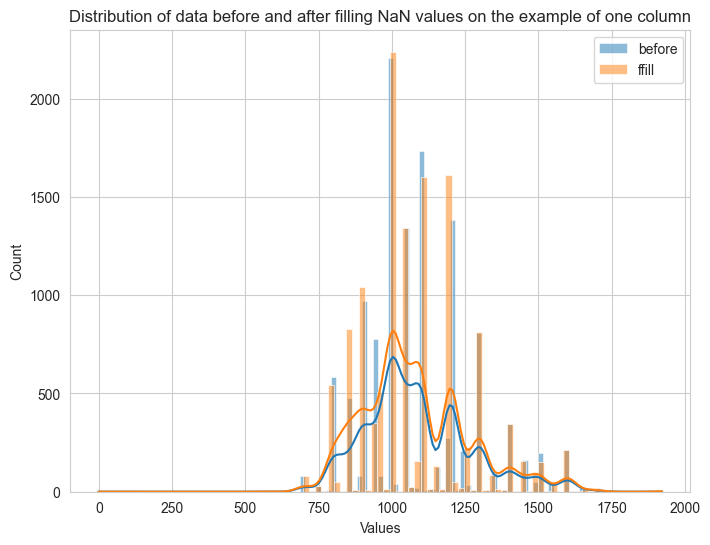

In [27]:
X_train = miss_val(X_train, "rougher.state.floatbank10_e_air")

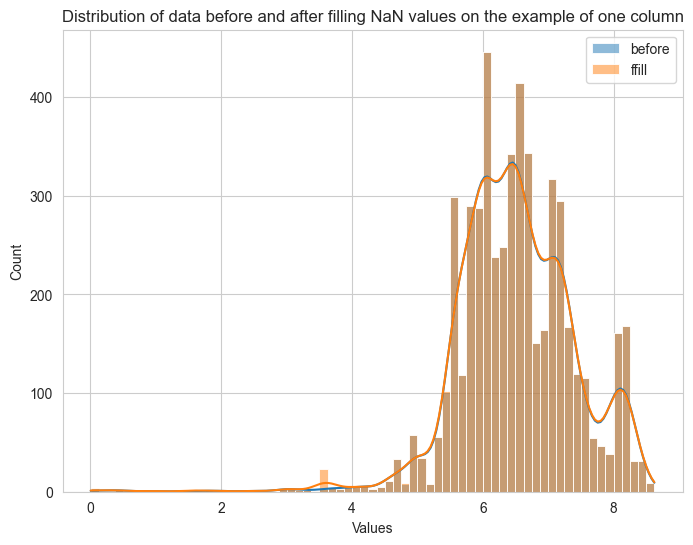

In [28]:
X_test = miss_val(X_test, "rougher.input.floatbank11_xanthate")

In [29]:
len(X_test[(X_test.isna()).any(axis=1)]), len(X_train[(X_train.isna()).any(axis=1)])

(0, 0)

In [30]:
len(X_train)

12936

In [31]:
def outlier_remover(df, left_border, right_border):

    min_max_before = df[X_test.columns].describe(percentiles=[0.0012, .9988]) \
            .drop(['count', 'mean', 'std'], axis=0).transpose()
    min_perc_sorted = (min_max_before["0.1%"] - min_max_before["min"])\
                          .sort_values(ascending=False).index[:5]
    # max_perc_sorted = (min_max_before["max"] - min_max_before["99.9%"])\
    #                       .sort_values(ascending=False).index[:5]

    old_outlier = df
    new_outlier = df
    for col in X_test.columns:
        z_1 = st.zscore(new_outlier[col])
        new_outlier = new_outlier.query("@left_border < @z_1 < @right_border")

    fig_1, ax_1 = plt.subplots(2, figsize=(12, 8), sharex="all")
    sns.boxplot(old_outlier[min_perc_sorted], orient="h", ax=ax_1[0])
    ax_1[0].set_title("Before remove outliers")
    sns.boxplot(new_outlier[min_perc_sorted], orient="h", ax=ax_1[1])
    ax_1[1].set_title("After remove outliers")

    return new_outlier

11511

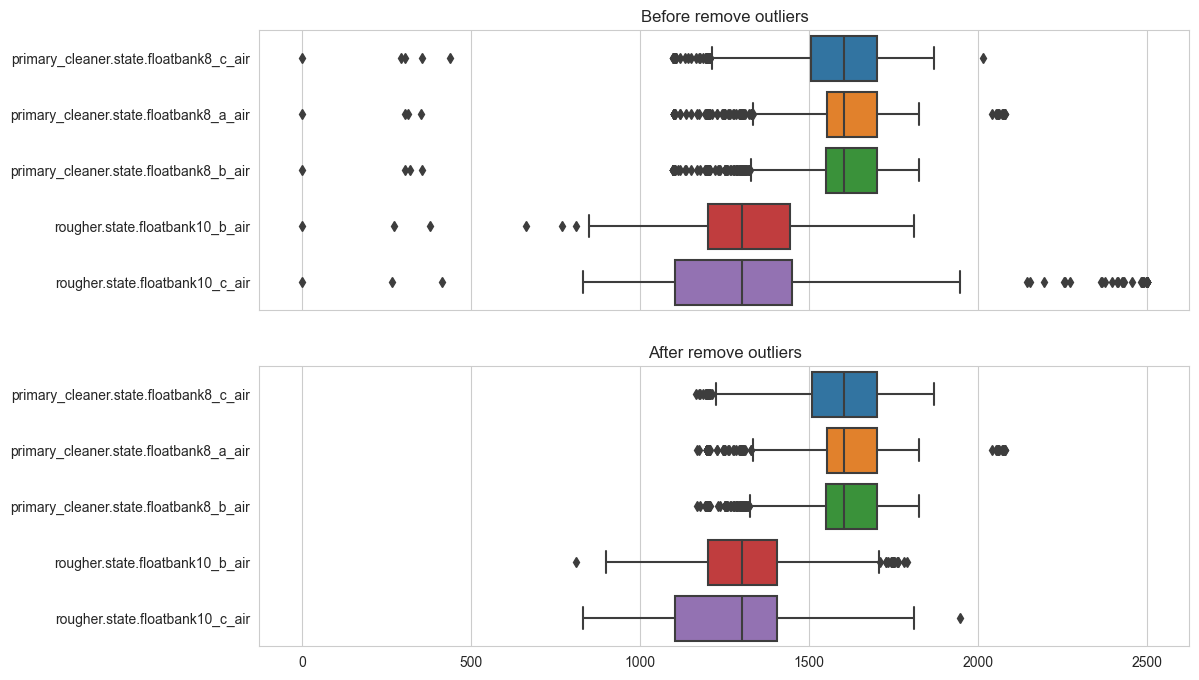

In [32]:
X_train = outlier_remover(X_train, -3.5, 4)
len(X_train)

In [33]:
# check duplicated row in combined dataset
sum(pd.concat([X_test, X_train]).duplicated())

0

### Вывод

Исходя из проделанной работы, были выполнены следующие этапы предобработки данных: приведение столбца с датой к соответствующему типу и конвертирование в индексы, удаление столбцов, отсутствующих в тестовой выборке, удаление строк с нулевыми значениями и заполнение пропусков соседними значениями. Эти шаги помогут снизить влияние шума и выбросов, а также предотвратить проблемы мультиколлинеарности и несбалансированности данных. Данные теперь готовы для дальнейшего анализа и построения модели.

## 3 Анализ данных

### Концентрация Au, Ag, Pb на различных этапах очистки

primary_cleaner — первичная очистка
secondary_cleaner — вторичная очистка

In [34]:
def get_columns(df, pattern, list_name=[], how=0):
    # Get column names that match the pattern
    matching_cols = [colm for colm in df.columns if pattern.match(colm)]
    stage_type = list(set([".".join(word1.split(".")[:2]) for word1 in matching_cols]))
    name_parameter = list(set([word.split(".")[-1] for word in matching_cols]))

    sns.set_style("white")
    if how == 0:
            _, axes_0 = plt.subplots(nrows=round(len(list_name)),
                                 ncols=1, figsize=(12, 6),
                                 sharex="all", sharey="all")
        for i, ax_1 in enumerate(axes_0):
            columns_for_graph = [s for s in matching_cols if list_name[i] in s]
            sns.kdeplot(data=df[columns_for_graph], ax=ax_1, fill=True)
            ax_1.set_title(list_name[i])
        plt.xlabel("Values")
    elif how == 1:
        _, axes_1 = plt.subplots(nrows=round(len(name_parameter)),
                                 ncols=1, figsize=(12, 6),
                                 sharex="none", sharey="none")
        for i, ax_1 in enumerate(axes_1):
            for sub_name in name_parameter:
                sns.kdeplot(data=df[stage_type[i]+"."+sub_name], ax=ax_1, fill=True, label=sub_name)
            ax_1.set_title(stage_type[i])
            ax_1.set_xlabel("Value")
            ax_1.legend()
    else:
        plt.figure(figsize=(12, 6))
        sum_conc = pd.DataFrame()
        for st in sorted(stage_type, reverse=True):
            step = [y for y in matching_cols if st in y]
            sum_conc[st] = X_train[step].sum(axis=1)
        sns.kdeplot(data=sum_conc, fill=True)
        plt.title("Total concentration of substances")
        plt.xlabel("Value")

    plt.tight_layout()
    sns.despine()
    plt.show()

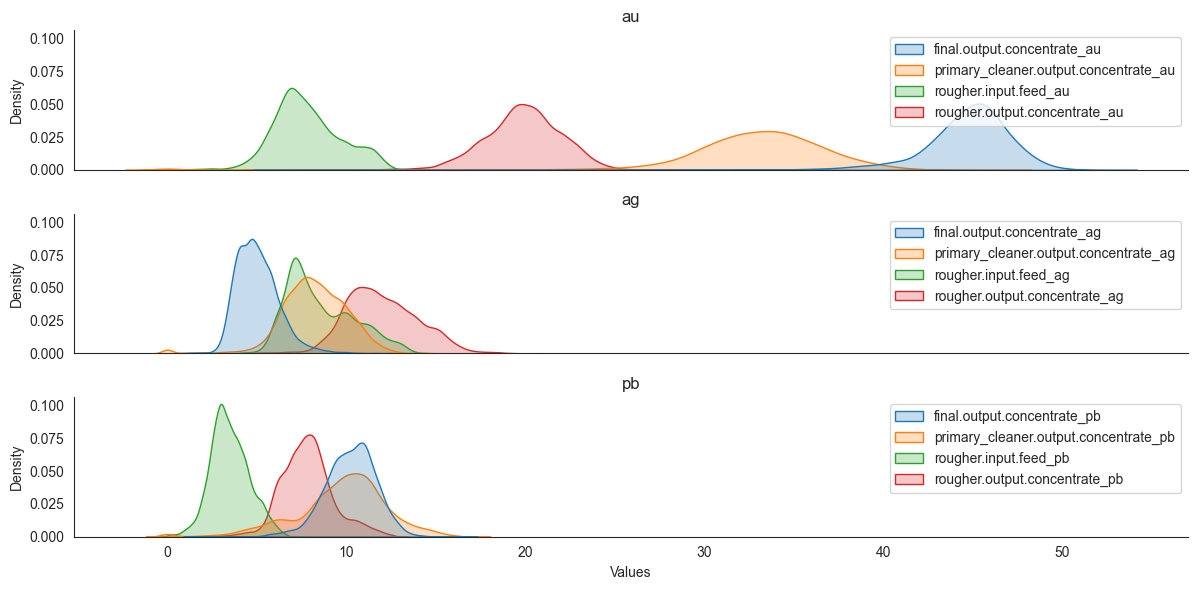

In [35]:
get_columns(X_train,
            pattern=re.compile(r'.+(concentrate|feed).+(au|ag|pb)'),
            list_name=["au", "ag", "pb"])

В процессе получения золота из золотоносной руды используется технология флотации и последующих этапов очистки. Целью этой технологии является повышение концентрации золота и отделение его от примесей.

Как показывают данные, концентрация золота повышается с каждым последующим этапом очистки, что подтверждает эффективность технологического процесса. Однако, следует учитывать, что концентрация серебра понижается с каждым шагом очистки. Следовательно, изначально присутствующее в руде серебро также отделяется от золота и других ценных металлов.

Также было замечено, что концентрация свинца повышается на этапе primary_cleaner после флотации. Это связано с использованием азотнокислого выщелачивания, в результате которого образуется много сульфата свинца в концентрате. Однако, повышение концентрации свинца также может быть связано с очищением других составляющих из золотоносной руды.

Таким образом, технологический процесс получения золота из руды включает несколько этапов флотации и очистки, на каждом из которых отделяются примеси от золота. Результаты анализа данных подтверждают, что этот процесс эффективен для повышения концентрации золота и отделения его от примесей, таких как серебро и свинец.

### Распределение размеров гранул сырья в обучающей и тестовой выборка

feed size — размер гранул сырья

In [36]:
feed_size_graph = X_train.reset_index(drop=True).join(X_test.reset_index(drop=True), rsuffix="_test")

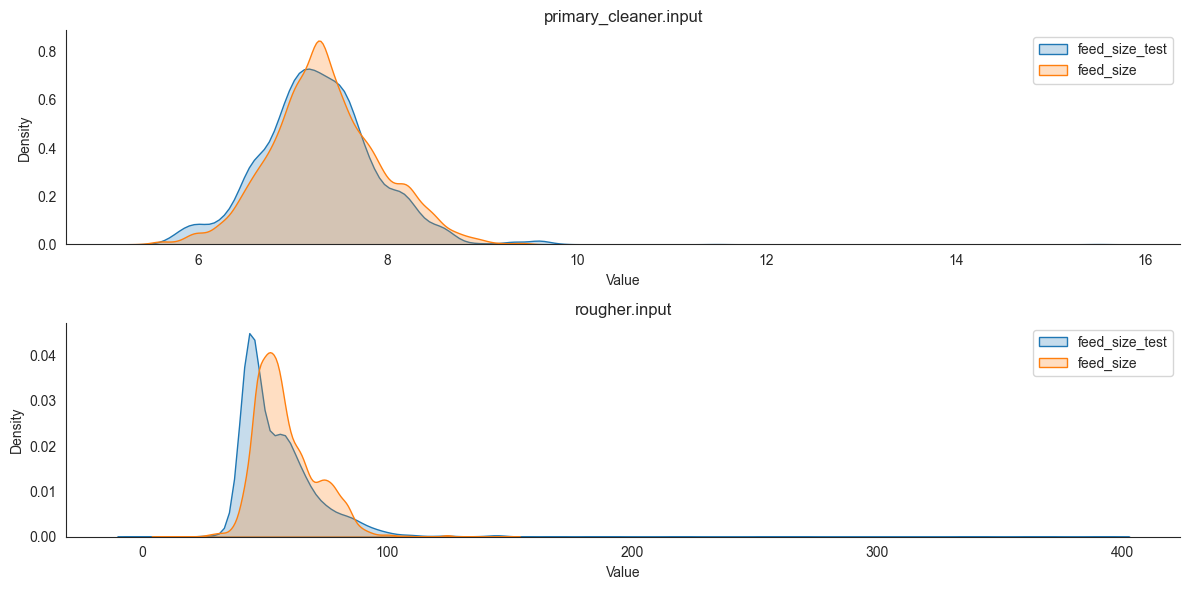

In [37]:
get_columns(feed_size_graph, pattern=re.compile(r'.+feed_size'), how=1)

На графике можно явно увидеть, что распределения похожи и размеры гранул сырья на обучающей и тестовой выборках практически идентичны. Это означает, что разница в размерах гранул на тестовой и обучающей выборках незначительна и не должна повлиять на оценку модели.

### Суммарная концентрации веществ на различных стадиях

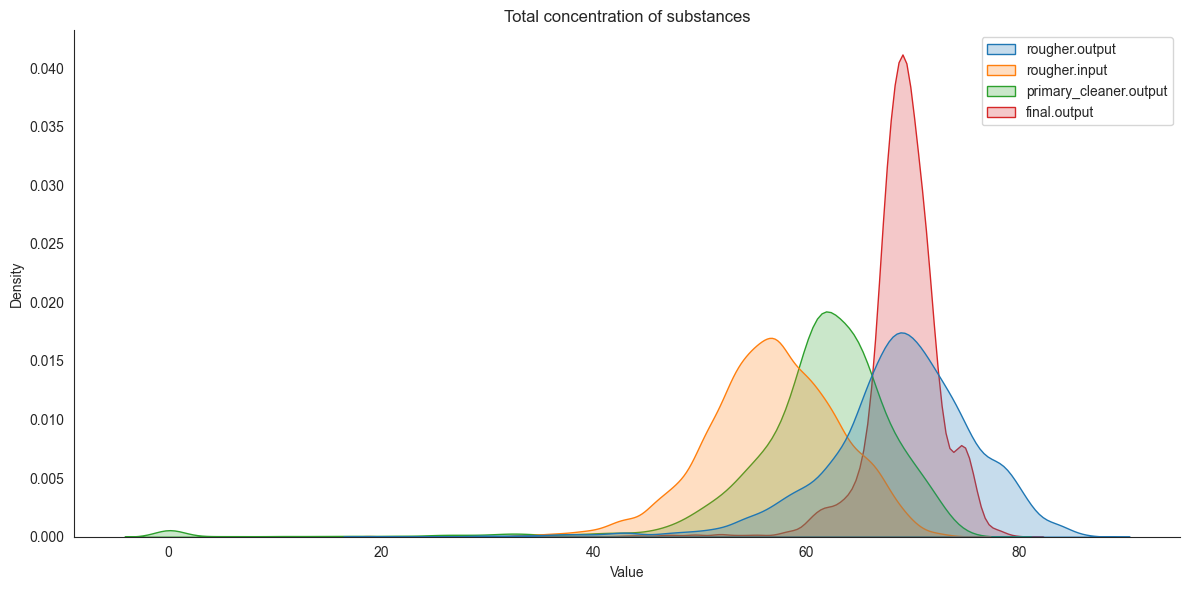

In [38]:
get_columns(X_train, re.compile(r'.+(concentrate|feed).(?!(size|calculation|rate))'), how=3)

Суммарная концентрация веществ увеличивается с каждым этапом обработки золотосодержащей руды в связи с удалением примесей и других металлов. На первых этапах процесса из руды удаляются более легкие примеси, что приводит к повышению концентрации золота и других благородных металлов. На последующих этапах процесса из руды удаляются более тяжелые примеси, что также приводит к повышению концентрации золота и снижению концентрации других металлов. Кроме того, на каждом этапе процесса применяются различные химические реагенты, которые влияют на концентрацию металлов в конечном продукте. Таким образом, суммарная концентрация веществ увеличивается с каждым этапом обработки золотосодержащей руды благодаря удалению примесей и других металлов, а также применению химических реагентов.

### Вывод

Технологический процесс получения золота из золотоносной руды является сложным и многокомпонентным процессом, который включает несколько этапов флотации и очистки. Целью этой технологии является повышение концентрации золота и отделение его от примесей. Результаты анализа данных показывают, что процесс эффективен для повышения концентрации золота и отделения его от примесей, таких как серебро и свинец. Суммарная концентрация веществ увеличивается с каждым этапом обработки золотосодержащей руды благодаря удалению примесей и других металлов, а также применению химических реагентов.


## 4 Обучение и тестирование модели

In [39]:
# remove the missing columns and create the targets
y_train_rougher = X_train["rougher.output.recovery"]
y_train_final = X_train["final.output.recovery"]
y_test_rougher = df_full.loc[X_test.index, "rougher.output.recovery"]
y_test_final = df_full.loc[X_test.index, "final.output.recovery"]
# X_train.drop(["rougher.output.recovery", "final.output.recovery"], axis=1, inplace=True)
X_train.drop(difference[difference.test != True].index, axis=1, inplace=True)

In [40]:
# # check the removing procedure
X_train.shape, X_test.shape

((11511, 52), (5289, 52))

In [41]:
# our own function for the metric of quality
def s_mape(true_values, predicts, **kwargs):

    metrics = sum(abs(true_values - predicts) * 2
        / (abs(true_values) + abs(predicts))) \
    / len(predicts) * 100

    return metrics

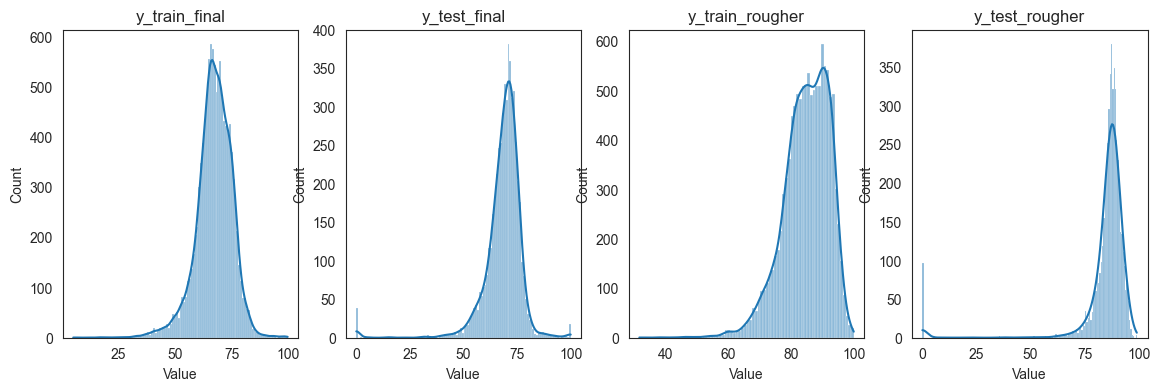

In [42]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4))
list_y = [y_train_final, y_test_final, y_train_rougher, y_test_rougher]
list_names = ["y_train_final", "y_test_final", "y_train_rougher", "y_test_rougher"]
for ax, i in zip(axs, range(len(list_y))):
    sns.histplot(list_y[i], kde=True, legend=True, ax=ax)
    ax.set_xlabel("Value")
    ax.set_title(list_names[i])

In [43]:
corr_matrix = X_train.corr()
corr_matrix_1 = corr_matrix[((corr_matrix > 0.9)
                             | (corr_matrix < -0.9))
                            & (corr_matrix != 1)]\
    .dropna(axis=0, how='all')
len(corr_matrix_1)

24

In [44]:
def get_better_model_1(trial):
    # create a list with the different algorithms
    regressor = trial.suggest_categorical('algorithm', ["LR", "Ridge", "Lasso", 'xgbr'])
    # create the statements with parameters for tha algorithms
    # also, define the model
    if regressor == "LR":
        regressor_obj = LinearRegression()

    elif regressor == "Ridge":
        param_ridge = {
            "alpha": trial.suggest_float("alpha", 0.05, 1.0),
            "random_state": RANDOM_STATE
        }
        regressor_obj = Ridge(**param_ridge)

    elif regressor == "Lasso":
        param_lasso = {
        "alpha": trial.suggest_float("alpha", 0.05, 1.0),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "selection": trial.suggest_categorical("selection", ["cyclic", "random"]),
        "random_state": RANDOM_STATE
        }
        regressor_obj = Lasso(**param_lasso)

    else:
        param_xgb = {
            "max_depth": trial.suggest_int("max_depth", 1, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.2, 1.0),
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_leaves": trial.suggest_int("max_leaves", 2, 10),
            "random_state": RANDOM_STATE
        }
        regressor_obj = xgb.XGBRegressor(**param_xgb)
    # put a suitable scaler inside a pipeline
    pipe_model = Pipeline(steps=[("scaler", RobustScaler()),
                                 ("regressor", regressor_obj)])
    # apply a transformer
    transformer = TransformedTargetRegressor(regressor=pipe_model,
                                             transformer=RobustScaler())
    # hide our dataset behind cross_val_score and put there our metric
    metric_rougher = cross_val_score(transformer, X_train, y_train_rougher,
                                   scoring=make_scorer(s_mape,
                                                       greater_is_better=False),
                                   n_jobs=-1).mean()
    # optimize by two metrics
    metric_final = cross_val_score(transformer, X_train, y_train_final,
                                   scoring=make_scorer(s_mape,
                                   greater_is_better=False),
                                   n_jobs=-1).mean()

    return metric_rougher, metric_final

# Create a study object and optimize the objective function
study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(get_better_model_1, n_trials=60)

[I 2023-04-20 00:18:34,451] A new study created in memory with name: no-name-b747aa99-db6a-4517-9984-0e036884f7f7
[I 2023-04-20 00:18:39,662] Trial 0 finished with values: [-7.072881630733866, -10.213810471681876] and parameters: {'algorithm': 'Ridge', 'alpha': 0.22610143180688014}. 
[I 2023-04-20 00:18:40,221] Trial 1 finished with values: [-7.074811474316213, -10.216136989795086] and parameters: {'algorithm': 'LR'}. 
[I 2023-04-20 00:18:40,653] Trial 2 finished with values: [-7.067510677091141, -10.207358947806528] and parameters: {'algorithm': 'Ridge', 'alpha': 0.8590874976305632}. 
[I 2023-04-20 00:18:41,141] Trial 3 finished with values: [-7.07322036396634, -10.21421894076212] and parameters: {'algorithm': 'Ridge', 'alpha': 0.1863276581342913}. 
[I 2023-04-20 00:18:41,758] Trial 4 finished with values: [-7.074811474316213, -10.216136989795086] and parameters: {'algorithm': 'LR'}. 
[I 2023-04-20 00:22:46,261] Trial 5 finished with values: [-6.488960309875422, -10.467642767451123] a

In [45]:
# check trials on Pareto
optuna.visualization.plot_pareto_front(study, target_names=["metric_rougher", "metric_final"]).show()
plt.show()

In [46]:
for i, name in zip([0, 1], ["rougher", "final"]):
    trial_with_highest_accuracy = max(study.best_trials, key=lambda t: t.values[i])
    print(f"Trial with highest sMape for {name}: ")
    print(f"\tnumber: {trial_with_highest_accuracy.number}")
    print(f"\tparams: {trial_with_highest_accuracy.params}")
    print(f"\tvalues: {abs(trial_with_highest_accuracy.values[i]):.2f}")

trial_value_rougher = max(study.best_trials, key=lambda t: t.values[0]).values[0]
trial_value_final = max(study.best_trials, key=lambda t: t.values[1]).values[1]
print(f'Common score for both targets is '
      f'{abs(0.25 * trial_value_rougher + 0.75 * trial_value_final):.2f}')

Trial with highest sMape for rougher: 
	number: 18
	params: {'algorithm': 'xgbr', 'max_depth': 1, 'learning_rate': 0.35413548211612167, 'n_estimators': 606, 'max_leaves': 6}
	values: 6.00
Trial with highest sMape for final: 
	number: 51
	params: {'algorithm': 'Lasso', 'alpha': 0.055114170451936, 'max_iter': 160, 'selection': 'random'}
	values: 8.89
Common score for both targets is 8.17


In [47]:
def evaluate_model(model_0, model_1):
    # make predictions for rougher and final targets
    y_pred_rougher = model_0.predict(X_test)
    y_pred_final = model_1.predict(X_test)

    # calculate score for rougher target
    s_mape_rougher = s_mape(y_test_rougher, y_pred_rougher)

    # calculate score for final target
    s_mape_final = s_mape(y_test_final, y_pred_final)

    # calculate common score
    common_score =  0.25 * s_mape_rougher + 0.75 * s_mape_final

    return y_pred_rougher, y_pred_final, s_mape_rougher, s_mape_final, common_score


In [48]:
def models_for_predict(optimize_model, X, y_r, y_f):
    best_models = []
    for i in range(2):
        # get the best model from the study
        best_model = max(optimize_model.best_trials, key=lambda t: t.values[i]).params
        type_algorithm = best_model.pop('algorithm')
        # create a pipeline with the best model
        if type_algorithm == "LR":
            regressor = LinearRegression()
        elif type_algorithm == "Ridge":
            regressor = Ridge(**best_model)
        elif type_algorithm == "Lasso":
            regressor = Lasso(**best_model)
        else:
            regressor = xgb.XGBRegressor(**best_model)

        best_pipe = Pipeline(steps=[("scaler", RobustScaler()),
                                    ("regressor", regressor)])

        transformer = TransformedTargetRegressor(regressor=best_pipe,
                                                 transformer=RobustScaler())

        # fit the pipeline on the full training data
        transformer.fit(X, y_r if i==0 else y_f)

        # evaluate the model on the test data
        best_models.append(transformer)

    return best_models

In [49]:
# build a Permutation explainer and explain the model predictions on the given dataset
def explain_features(best_models, X_train, X_test):
    explainer = shap.explainers.Permutation(best_models.predict, X_train)
    shap_values = explainer(X_test[:1000])

    # get just the explanations for the positive class
    shap_values = shap_values[1]
    shap.plots.bar(shap_values, max_display=10)
    plt.show()

In [50]:
# create the models for prediction targets
best_models = models_for_predict(study, X_train, y_train_rougher, y_train_final)

C:\Users\Ludmila\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.564e+00, tolerance: 8.312e-01



Permutation explainer: 1001it [02:06,  7.41it/s]                          


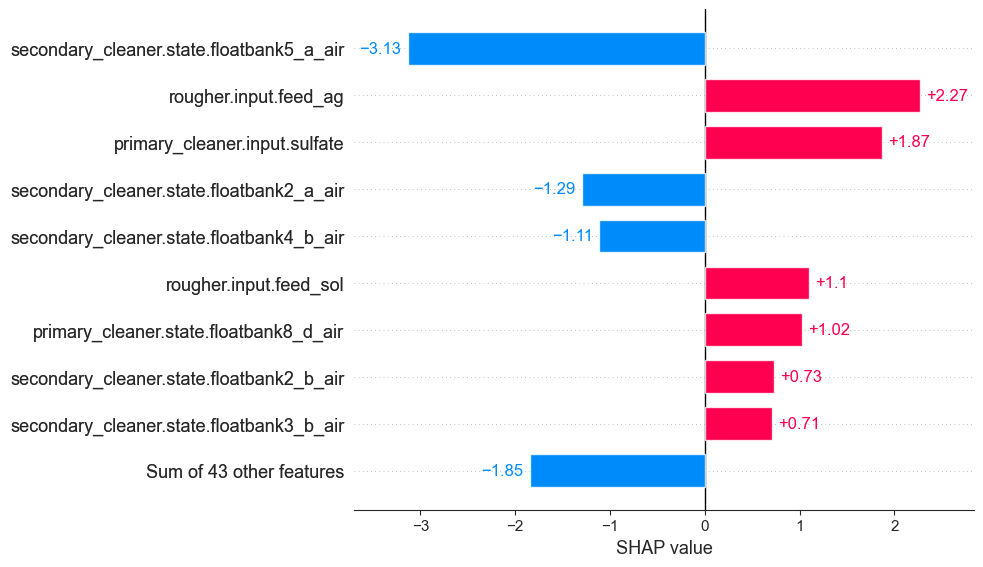

Permutation explainer: 1001it [00:48, 16.55it/s]                         


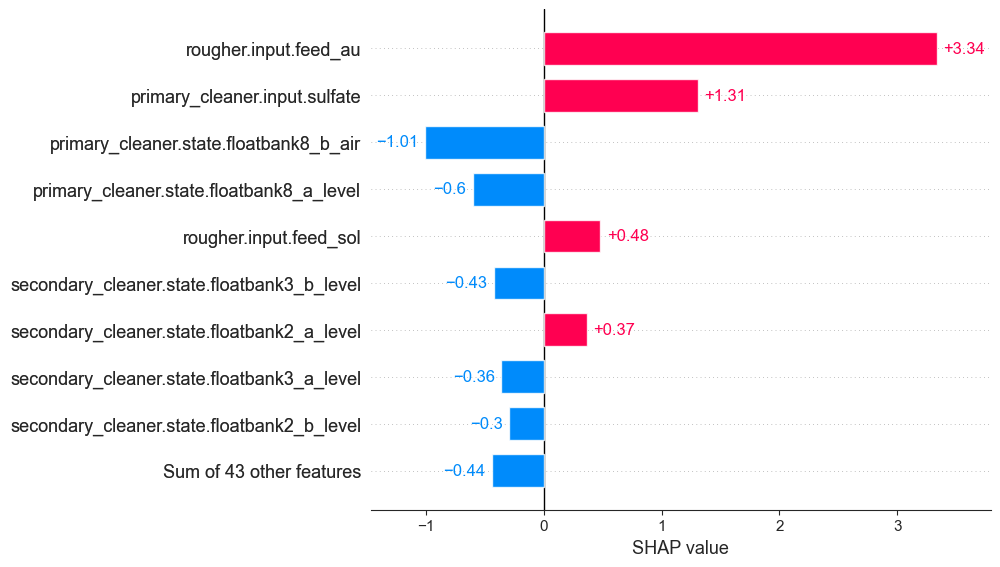

In [51]:
# look at influence features on models quality for each targets
explain_features(best_models[0], X_train, X_test)
explain_features(best_models[1], X_train, X_test)

In [52]:
# get predictions and metrics
y_pred_rougher, y_pred_final, \
    s_mape_rougher, s_mape_final, common_score = evaluate_model(best_models[0], best_models[1])

In [53]:
print(f"Getting score for rougher target is {s_mape_rougher: .2f}% \n"
f"Getting score for final target is {s_mape_final:.2f}% \n"
f"Common score for both targets is {common_score:.2f}%")

Getting score for rougher target is  8.43% 
Getting score for final target is 8.84% 
Common score for both targets is 8.74%


In [54]:
a = s_mape(y_test_rougher, np.array([y_train_rougher.median()] * len(y_test_rougher)))
b = s_mape(y_test_final, np.array([y_test_final.median()] * len(y_test_final)))
print(f"Common median score for dummy-model is {(0.25 * a + 0.75 * b):.2f}%")

Common median score for dummy-model is 8.96%


### Вывод
Данные представляют собой множество коррелирующий столбцов, с выбросами и отсутствием нормального распределения, в том числе и в целевых признаках. Для обучения были выбраны 4 модели: Lasso, Ridge, xgb.Regressor и LinearRegression. Линейная регрессия, как наиболее простая модели служила показателем адекватности перебора параметров, если бы данный алгоритм показал удовлетворительные результаты, что говорило бы о необходимости проверки внутренних циклов оптимизатора(Pipeline, cross_val_score и т.д). Оптимизация велась по двум метрикам для двух целевых признаков: эффективность обогащения чернового концентрата(rougher.output.recovery) и эффективность обогащения финального концентрата(final.output.recovery). Метрика оптимизации - собственная метрика sMAPE.

Для 50-ти итераций обучения, распределение оценок двух метрик, в основном, находится: ниже 7.5 для чернового концентрата и ниже 10 для финального. По оценке оптимизатора наиболее подходящий алгоритм на обучащей выборке для чернового концентрата - xgb.Regressor, с предсказательной способностью по метрике sMAPE 6.07%. Для эффективности обогащения финального концентрата по модели Lasso - 9.36%. Выбор Lasso для финального концентрата, вероятнее всего, обусловлен большим количеством коррелирующих признаков. Финальная метрика для двух целевых показателей на обучающей выборке - 8.54%. Таким образом абсолютная ошибка между предсказанными и истинными значениями составила 8.54%. На тестовой выборке результаты для чернового концентрата - 8.28%, для финального концентрата -8.88%, общая предсказательная ошибка - 8.73%, что на 0.23% ниже модели, предсказывающей медианные значения.

Если говорить о качественном анализе, то можно увидеть на графиках SHAP value негативное влияние признаков на эффективности обогащения финального концентрата. Наибольшее негативное влияние оказывают:
    * уровень жидкости во флотационной установке 10 на этапе флотации;
    * объем воздуха во флотационной установке 2 на этапе флотации;
    * объем воздуха во флотационной установке 3 на этапе вторичной очистки.

Основное положительное влияние на эффективность обогащения финального концентрата оказывает размер гранул золота на этапе флотации. Негативное влияние на эффективность обогащения чернового концентрата оказывают:
     * уровень жидкости во флотационной установке 3 на этапе вторичной очистки;
     * объем воздуха во флотационной установке 2 на этапе вторичной очистки;
     * уровень жидкости во флотационной установке 2 на этапе вторичной очистки;
     * объем воздуха во флотационной установке 4 на этапе вторичной очистки;
     * уровень жидкости во флотационной установке 5 на этапе вторичной очистки.

Наиболее положительное влияние оказывает качество сульфида натрия(флотационный реагент) на этапе вторичной очистки.



## 5 Заключение


### Вывод

Предварительная обработка данных является важным этапом в решении задач машинного обучения. В данном случае было обнаружено множество нулевых значений, которые были удалены, поскольку они могут повлиять на результаты обучения модели. Были также удалены столбцы, отсутствующие в тестовой выборке, и заполнены пропуски соседними значениями. Эти действия направлены на снижение влияния шума и выбросов, а также предотвращения проблемы мультиколлинеарности и несбалансированности данных. Важно отметить, что уточнение дополнительных сведений у заказчика могло бы помочь лучше понять данные и увеличить точность модели.


Для решения задачи предсказания эффективности обогащения чернового и финального концентрата были выбраны четыре модели: Lasso, Ridge, xgb.Regressor и LinearRegression. Оптимизация моделей велась с использованием собственной метрики sMAPE. Эта метрика симметрична по отношению к прогнозам и фактическим значениям и учитывает процентное отклонение между ними. Кроме того, sMAPE более интерпретируема для бизнес-задач, чем, например, RMSE или MSE, поскольку результаты измеряются в процентах ошибки.

Из результатов оптимизации можно сделать вывод, что для предсказания эффективности обогащения чернового концентрата наилучшей моделью оказалась xgb.Regressor, а для финального концентрата - Lasso. Различие в выбранных моделях может быть обусловлено большим количеством коррелирующих признаков в целевом признаке финального концентрата.

Общая предсказательная ошибка на тестовой выборке составила 8.73%, что немного лучше, чем модель, предсказывающая медианные значения. Однако, необходимо провести дополнительные исследования, чтобы определить, насколько точно можно предсказывать эффективность обогащения на основе имеющихся признаков и выбранных моделей, а также насколько это будет полезно в практических приложениях.

 Анализ данных показал, что технологический процесс обогащения золотоносной руды является эффективным способом повышения концентрации золота и отделения его от примесей. Некоторые параметры процесса могут негативно влиять на эффективность обогащения финального концентрата. Размер гранул золота на этапе флотации и качество флотационного реагента на этапе вторичной очистки оказывают наиболее положительное влияние на процесс. Оптимизация использования химических реагентов и улучшение управления параметрами процесса могут повысить эффективность производства и увеличить количество получаемого золота.

Для оптимизации производства на основе этих данных, можно предпринять следующие шаги:

1. Определить оптимальный уровень жидкости и объем воздуха во флотационных установках. Для этого можно провести дополнительные исследования и определить оптимальный диапазон для каждого параметра.

2. Улучшить использование химических реагентов.

3. Оптимизировать размер гранул золота на этапе флотации.

4. Улучшить управление параметрами процесса. Для этого можно использовать автоматизированную систему управления, которая будет контролировать параметры процесса и корректировать их, если необходимо.

5. Инвестировать в современное оборудование и технологии.

Проведение этих мероприятий может помочь увеличить количество получаемого золота и повысить эффективность производственного процесса.


